In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install lightgbm

In [4]:
pip install polars


In [5]:
pip install xgboost

In [6]:
pip install pyarrow


In [7]:
import warnings
warnings.filterwarnings('ignore')
import gc
import ctypes
import os
import itertools
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import pprint
import time
import copy
import lightgbm as lgb
import torch
import polars as pl
import optuna

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn import metrics
%matplotlib inline
from random import choice, choices
from functools import reduce, partial
from tqdm import tqdm
from itertools import cycle
from collections import Counter
from scipy import stats
from scipy.stats import skew, kurtosis
from transformers import BertTokenizer
from collections import Counter, defaultdict
from tqdm.autonotebook import tqdm
from math import sqrt
from sklearn import model_selection

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()
clean_memory()

Below -
The first function rebuilds the text of each essay, and the second function organises these texts into a data frame suitable for further analysis or display.


In [8]:
def reconstruct_essay(currTextInput):
    essayText = ""  #initialise an empty string to build the reconstructed essay text.
    for Input in currTextInput.values:  #Iterate over the values in the currTextInput DataFrame.
        if Input[0] == 'Replace':
            #Handle the 'Replace' operation.
            replaceTxt = Input[2].split(' => ')  #Split the replacement instruction into old and new text.
            # Replace the specified portion of the text.
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':
            # Handle the 'Paste' operation.
            # Insert the text from Input[2] at the specified position.
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':
            # Handle the 'Remove/Cut' operation.
            # Remove the specified portion of text.
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:
            # Handle the 'Move' operation.
            croppedTxt = Input[0][10:]  # Remove the prefix from the move command.
            splitTxt = croppedTxt.split(' To ')  # Split the move command by ' To ' to get source and target.
            valueArr = [item.split(', ') for item in splitTxt]  # Split each part into tuples of positions.
            # Convert these position strings into tuples of integers.
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:
                # Ensure the source and target columns are different.
                if moveData[0] < moveData[2]:
                    # Handle forward moving of text.
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    # Handle backward moving of text.
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        # Default editing action (e.g., typing in new text at a specified position).
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText  # Return the reconstructed essay.



# This function processes a DataFrame df that contains multiple essays data, filtering and reconstructing each essay.
def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df

In [9]:
traindf = pd.read_csv('/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_scores.csv')
testdf = pd.read_csv('/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/test_logs.csv')

In [10]:
#%%time


train_essays = get_essay_df(traindf)

test_essays = get_essay_df(testdf)
train_essaysdf = pd.DataFrame({'id': train_essays.id, 'essay': train_essays.essay})
test_essaysdf = pd.DataFrame({'id': test_essays.id, 'essay': test_essays.essay})

merged_data = train_essaysdf.merge(train_scores, on='id')

In [11]:
merged_data

id                                              essay  score
0     001519c8  qqqqqqqqq qq qqqqq qq qqqq qqqq.  qqqqqq qqq q...    3.5
1     0022f953  qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...    3.5
2     0042269b  qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...    6.0
3     0059420b  qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...    2.0
4     0075873a  qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...    4.0
...        ...                                                ...    ...
2466  ffb8c745       qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq qq...    3.5
2467  ffbef7e5  qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqqq...    4.0
2468  ffccd6fd  qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqqq...    1.5
2469  ffec5b38  qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qqq...    5.0
2470  fff05981  qq qqqq qqqqqqq qqqqqqqq qq qqqqqqqqqqq qq qq ...    4.0

[2471 rows x 3 columns]

*CountVectorizer* for character-level analysis of essays to extract features in the form of character n-grams. It then applies this vectorization to both training and test datasets to prepare them for machine learning tasks which will be training a model to predict essay scores.

In [12]:
# Create an instance of CountVectorizer to convert a collection of text documents to a matrix of token counts.
# This instance is configured to consider character n-grams from 1 to 4 (inclusive) within word boundaries.
count_vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='char_wb')

# Fit the vectorizer on the essay text from the training data and transform the text to a token count matrix.
X_tokenizer_train = count_vectorizer.fit_transform(merged_data['essay'])

# Transform the essay text from the test data using the already fitted vectorizer to the same token count matrix format.
X_tokenizer_test = count_vectorizer.transform(test_essaysdf['essay'])

# Retrieve and print the feature names (here, the character n-grams) that have been extracted from the essays.
count_vectorizer.get_feature_names_out()  # This line is used to inspect the token names used in the model.

# Extract the scores from the merged training data to use as labels for training the model.
y = merged_data['score']


In [13]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

transforms token count matrices (originating from CountVectorizer) from sparse to dense format. It then iterates through each feature (column) in these matrices to create individual feature columns in new DataFrames (df_train and df_test). Each feature is named sequentially (feature 0, feature 1, etc.) and is added to the respective DataFrame.

In [14]:
# Convert the sparse matrix 'X_tokenizer_train' to a dense matrix.
X_tokenizer_train = X_tokenizer_train.todense()

# Similarly, convert the sparse matrix 'X_tokenizer_test' to a dense matrix.
X_tokenizer_test = X_tokenizer_test.todense()

# Iterate over each column of the dense matrix corresponding to the training data.
for i in range(X_tokenizer_train.shape[1]):
    L = list(X_tokenizer_train[:, i])  # Extract the column as a list of elements.
    li = [int(x) for x in L]  # Convert each element in the list to an integer.
    df_train[f'feature {i}'] = li  # Add a new column to the training DataFrame for this feature.

# Repeat the process for the test data.
for i in range(X_tokenizer_test.shape[1]):
    L = list(X_tokenizer_test[:, i])  # Extract the column as a list of elements.
    li = [int(x) for x in L]  # Convert each element in the list to an integer.
    df_test[f'feature {i}'] = li  # Add a new column to the test DataFrame for this feature.


The below --

Assigning the 'id' column from train_essaysdf and test_essaysdf DataFrames to the df_train and df_test DataFrames respectively

In [15]:
df_train_index = train_essaysdf['id']
df_test_index = test_essaysdf['id']

df_train.loc[:, 'id'] = df_train_index
df_test.loc[:, 'id'] = df_test_index

In [16]:
import polars as pl
import pandas as pd
import numpy as np
import re
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.stats import skew, kurtosis
import warnings
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [17]:
# Define lists of column names and activity/event types to be used in feature generation.
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']

# Define a function to count occurrences of specified values in a column and return a dataframe with these counts.
def count_by_values(df, colname, values):
    fts = df.select(pl.col('id').unique(maintain_order=True))  # Extract unique IDs.
    for i, value in enumerate(values):
        # Group by 'id' and count occurrences of each value in the specified column.
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        fts = fts.join(tmp_df, on='id', how='left')  # Join these features back to the main features DataFrame.
    return fts

# Define a function to develop a comprehensive set of features based on user interactions.
def dev_feats(df):
    print("< Count by values features >")
    # Generate counts for different activities and text changes.
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left')
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left')
    feats = feats.join(count_by_values(df, 'up_event', events), on='id', how='left')

    print("< Input words stats features >")
    # Filter out rows where 'text_change' does not involve replacements or no changes, and extract statistics on words inputted.
    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.lengths(),
                             input_word_length_mean = pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left')

    print("< Numerical columns features >")
    # Compute summary statistics for numerical columns.
    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'), pl.mean(num_cols).suffix('_mean'), pl.std(num_cols).suffix('_std'),
                                 pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                 pl.quantile(num_cols, 0.5).suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left')

    print("< Categorical columns features >")
    # Count the number of unique entries in categorical columns.
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left')

    print("< Idle time features >")
    # Calculate time differences between key events to analyse idle times.
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter(pl.col('time_diff') > 2).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    feats = feats.join(temp, on='id', how='left')

    print("< P-bursts features >") # Begin section for P-bursts features, which are based on typing speed bursts.

    # Add a column 'up_time_lagged' which shifts 'up_time' by one row within each 'id'.
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    # Calculate the time difference between consecutive key events, convert to seconds, and fill null values with 0.
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    # Filter rows to include only 'Input' and 'Remove/Cut' activities for burst analysis.
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    # Keep time differences that are less than 2 seconds, considering them as part of a burst of rapid typing.
    temp = temp.with_columns(pl.col('time_diff')<2)
    # Calculate P-bursts using run-length encoding (RLE); count the occurrences where 'time_diff' is less than the last time_diff in its group.
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'), pl.std('P-bursts').suffix('_std'), pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'), pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'), pl.last('P-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left')

    # Begin section for R-bursts features, focusing on bursts of 'Remove/Cut' activities.
    print("< R-bursts features >")

    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    temp = temp.drop_nulls() #drop with any null
    temp = temp.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'), pl.std('R-bursts').suffix('_std'),# Group by 'id' and aggregate statistics for R-bursts.
                                   pl.median('R-bursts').suffix('_median'), pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'), pl.last('R-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left')


    #Return the enhanced features DataFrame.
    return feats


In [18]:
def q1(x):
    return x.quantile(0.1)  # returns 10th percentile of the data
def q2(x):
    return x.quantile(0.25) # 25th
def q7(x):
    return x.quantile(0.75)
def q9(x):
    return x.quantile(0.90)

AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q2, 'median', q7,'sum']

def reconstruct_essay(currTextInput):
    essayText = ""  # Initialise an empty string to build the essay text.
    for Input in currTextInput.values:     # Iterate over each edit recorded.
        if Input[0] == 'Replace':  # Handle the 'Replace' operation.
            replaceTxt = Input[2].split(' => ')  # Split the change instruction into original and new text.
            # Replace the specified portion of text.
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':  # Handle the 'Paste' operation.
            # Insert text at the specified cursor position.
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':  # Handle the 'Remove/Cut' operation.
            # Remove the specified portion of text.
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        if "M" in Input[0]:  # Handle the 'Move' operation.
            croppedTxt = Input[0][10:]  # Extract the substring that describes the move operation.
            splitTxt = croppedTxt.split(' To ')  # Split into source and destination details.
            valueArr = [item.split(', ') for item in splitTxt]  # Extract positions as lists of strings.
            # Convert position strings to tuples of integers.
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            if moveData[0] != moveData[2]:  # Check if the move is within the same column (not needed here but included for robustness).
                if moveData[0] < moveData[2]:  # If moving forward in the text.
                    # Perform the move operation in the forward direction.
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:  # If moving backward in the text.
                    # Perform the move operation in the backward direction.
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]# Default case for inserting text.
    return essayText  # Return the fully reconstructed essay text.

#This function processes a dataframe to exclude non-productive activities and reconstructs essays based on edit logs.
def get_essay_df(df):
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df

#This function generates features based on word lengths within essays.
def word_feats(df):
    essay_df = df
    # Split essays into words using regular expressions to handle spaces and punctuation.
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!', x))
    df = df.explode('word')  # Transform each element of a list-like to a row, replicating the index values.
    df['word_len'] = df['word'].apply(lambda x: len(x))  # Calculate the length of each word.
    df = df[df['word_len'] != 0]  # Filter out empty words.

    # Group by 'id' and calculate aggregated statistics for word lengths.
    word_agg_df = df[['id', 'word_len']].groupby(['id']).agg(AGGREGATIONS)
    # Rename columns to reflect the type of aggregation applied.
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df  # Return the DataFrame containing aggregated word features.

#This function processes essays to extract sentence-based features, such as sentence length and word count per sentence.
def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS),
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

#generates features based on paragraphs within the essays, including paragraph length and word count.
def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x))
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)

    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS),
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df
# calculates the ratio of total characters in the essays to the number of key press actions.
def product_to_keys(logs, essays):
    essays['product_len'] = essays.essay.str.len()
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]
#This function calculates the rate of key presses per second based on activity logs.
def get_keys_pressed_per_second(logs):
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]

###performs target encoding for categorical features, useful for handling categories with a significant impact on the target variable.
def target_encoding(train_df, scores, feature):
    train_df['target'] = train_df['id'].map(dict(scores.values))
    down_event_counts = train_df[feature].value_counts()
    rare_down_events = down_event_counts[down_event_counts <= 3].index
    # Replace 'target' values with NaN for these rare events
    train_df.loc[train_df[feature].isin(rare_down_events), 'target'] = np.nan

    # Step 2: Calculate the mean 'target' for each 'down_event'
    mean_target_by_down_event = train_df.groupby(feature)['target'].mean().reset_index(name=f'{feature}_mean_target')
    train_df.drop(columns=["target"], inplace=True)

    return mean_target_by_down_event

    ###These functions are tailored to extract rich linguistic and productivity features from text data,

In [19]:
pip install pyarrow


In [20]:
pip install pyarrow


In [21]:
# Print a message indicating the start of the data reading process.
print('< Read Data >')

# Define the paths to your datasets stored on Google Drive.
train_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_logs.csv'
train_scores_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_scores.csv'
test_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/test_logs.csv'

# Start processing the training data.
# Read the log data using polars' lazy loading, which is efficient for large datasets.
train_logs = pl.scan_csv(train_logs_path)
# Process the logs to extract features using a custom function `dev_feats`.
train_feats = dev_feats(train_logs)
# Collect the computed features into a pandas DataFrame.
train_feats = train_feats.collect().to_pandas()
# Read the scores data which will be used as labels or targets in model training.
train_scores = pd.read_csv(train_scores_path)
# Collect the training logs data and remove a specific problematic row by its index.
train_logs = train_logs.collect().to_pandas().drop([850340], axis=0)

# Start processing the testing data similarly to training data.
test_logs = pl.scan_csv(test_logs_path)
test_feats = dev_feats(test_logs)
test_feats = test_feats.collect().to_pandas()
test_logs = test_logs.collect().to_pandas()

# Print a message indicating the start of the training feature engineering process.
print('< Train Features >')
# Generate essays from logs and merge various linguistic and activity-based features.
train_essays = get_essay_df(train_logs)
train_feats = train_feats.merge(word_feats(train_essays), on='id', how='left')
train_feats = train_feats.merge(sent_feats(train_essays), on='id', how='left')
train_feats = train_feats.merge(parag_feats(train_essays), on='id', how='left')
train_feats = train_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
train_feats = train_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')

# Merge additional training features stored in `df_train` with the main feature DataFrame.
train_feats = train_feats.merge(df_train, on='id', how='left')

print('< Train Features >')  # This should likely be '< Test Features >' to match the context.
test_essays = get_essay_df(test_logs)
test_feats = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')

# Merge additional test features stored in `df_test` with the main feature DataFrame.
test_feats = test_feats.merge(df_test, on='id', how='left')

# Print a message indicating completion of the feature engineering process.
print('Finished!!!!')


< Read Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Train Features >
< Train Features >
Finished!!!!


Explanation of Key Steps For Below


CountVectorizer:

It's used to convert the text data into a format that can be used by machine learning algorithms. This step converts text into a sparse matrix of token counts, focusing only on words that aren't English stop words, which are typically high-frequency but low-information words in the context of topic modeling.

Document-Term Matrix:

After fitting, the essays are transformed into a matrix where each row corresponds to a document (an essay in this case) and each column represents a unique word across all documents. The values in the matrix represent the count of each word in each document.

Latent Dirichlet Allocation (LDA):

This is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. In the context of text data, these unobserved groups are topics, and the LDA model attempts to back out what topics would have generated the given documents based on the distribution of words in the documents.


Model Fitting and Transformation:

The LDA model is fitted using both train and test data to ensure a comprehensive understanding of all possible word combinations and their topic associations. Post fitting, each essay's document-term matrix is transformed into a topic distribution which indicates the percentage contribution of each topic to the document.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the CountVectorizer with English stop words to exclude them from the analysis.
CouVec = CountVectorizer(stop_words='english')
# Concatenate the training and testing essays into a single DataFrame for fitting the vectorizer.
df = pd.concat([train_essays, test_essays])
# Fit the CountVectorizer on the essays to learn a vocabulary dictionary of all tokens in the raw documents.
CouVec.fit(df['essay'])
# Transform the essays into a document-term matrix using the fitted CountVectorizer.
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())
# Import the LatentDirichletAllocation module for performing LDA.
from sklearn.decomposition import LatentDirichletAllocation
# Define the number of topics (clusters) for the LDA model.
n_clusters = 6
# Initialise the LDA model with specified number of components and other parameters.
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
# Fit the LDA model on the concatenated train and test document-term matrices to find patterns or topics.
LDA.fit(pd.concat([train_words, test_words]))

# Generate topic labels for each cluster.
Topics = [f'Topic_{x}' for x in range(0, n_clusters)]
# Transform the document-term matrices to get the topic distribution for each document.
# The resulting matrix indicates the proportion of each topic in each document.
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Character N-grams with CountVectorizer:

The analyzer='char_wb' setting in CountVectorizer configures it to extract character n-grams from the text, considering only those that appear within word boundaries. This approach can be particularly useful for capturing language patterns like suffixes and prefixes, and it's less sensitive to misspellings than word-based analysis.


Document-Term Matrix:

Similar to the previous explanation, the essays are converted into a matrix of character n-gram frequencies. Each row represents an essay, and each column represents a unique character n-gram identified across all essays.


Latent Dirichlet Allocation (LDA) Configuration:

The configuration remains the same, aiming to model topics based on the distribution of character n-grams in the essays. Fitting the model on the combined train and test data helps in achieving a comprehensive understanding of the textual data.


Application and Transformation:

After fitting, the LDA model is used to transform the training and testing datasets separately. The transformation results in the topic distributions for each essay, which are then added to the respective feature DataFrames (train_feats and test_feats). These features can be particularly insightful for tasks that benefit from understanding the thematic structure or stylistic elements of the text.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
CouVec = CountVectorizer(analyzer='char_wb')  # Initialise the CountVectorizer to use character n-grams within word boundaries.
df = pd.concat([train_essays,test_essays])
CouVec.fit(df['essay'])
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())

from sklearn.decomposition import LatentDirichletAllocation
n_clusters = 6
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
LDA.fit(pd.concat([train_words,test_words]))
Topics = [f'_Topic_{x}' for x in range(0,n_clusters)]
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Character N-grams:

Using ngram_range=(5, 6) specifies that the vectorizer should consider only character n-grams that are 5 to 6 characters long. This choice can capture significant character patterns prevalent in the language of the essays, such as common parts of words or word endings, which can be particularly telling in terms of writing style or content.


CountVectorizer Setup:

analyzer='char_wb' ensures that n-grams are created based on characters but only taken from within word boundaries, which helps avoid creating n-grams spanning spaces and punctuation, thus keeping the analysis more focused on actual linguistic content.


Latent Dirichlet Allocation (LDA):

LDA is used here to model topics found in both the training and testing datasets, identifying underlying thematic structures based on the character n-gram frequencies. The choice of n_clusters=6 aims to distill the essays into 6 distinct topics, which should reveal the dominant themes or styles across the corpus.



Integration with Feature DataFrames:

After modeling, the topic distributions (train_feats and test_feats) are updated to include the new features derived from the LDA transformations. These features, named as __Topic_0 to __Topic_5, represent the proportion of each essay's content that aligns with the modeled topics, providing rich features that can be used for subsequent analysis or predictive modeling.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
CouVec = CountVectorizer(analyzer='char_wb',ngram_range=(5, 6))
df = pd.concat([train_essays,test_essays])
CouVec.fit(df['essay'])
train_words = pd.DataFrame(CouVec.transform(train_essays['essay']).toarray())
test_words = pd.DataFrame(CouVec.transform(test_essays['essay']).toarray())

from sklearn.decomposition import LatentDirichletAllocation
n_clusters = 6
LDA = LatentDirichletAllocation(n_components=n_clusters, max_iter=10, random_state=42, verbose=True)
LDA.fit(pd.concat([train_words,test_words]))
Topics = [f'__Topic_{x}' for x in range(0,n_clusters)]
train_feats[Topics] = LDA.transform(train_words)
test_feats[Topics] = LDA.transform(test_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [25]:
feats = ['paragraph_count',
 'inter_key_median_lantency',
 'feature 1048',
 'feature 1049',
 'feature 1120',
 'feature 448',
 'feature 449',
 'feature 846',
 'feature 847',
 'feature 65',
 'feature 138',
 'feature 141',
 'text_change_7_cnt',
 'sent_word_count_median',
 'feature 1023',
 'feature 1031',
 'feature 335',
 'feature 364',
 'feature 365',
 'feature 789',
 'feature 808',
 'feature 809',
 'R-bursts_median',
 'Topic_4',
 'cursor_position_max',
 'feature 0',
 'feature 1108',
 'feature 1109',
 'feature 1130',
 'feature 126',
 'feature 168',
 'feature 185',
 'feature 719',
 'feature 720',
 'feature 992',
 'feature 993',
 'paragraph_len_sum',
 'sent_len_sum',
 'sent_word_count_sum',
 'word_count_max',
 'word_count_std',
 'word_len_count',
 'word_len_sum',
 'action_time_max',
 'down_event_3_cnt',
 'up_event_3_cnt',
 'pauses_1_half_sec',
 'paragraph_word_count_q2',
 'product_to_keys',
 'paragraph_len_max',
 'text_change_6_cnt',
 'feature 1124',
 'feature 580',
 'feature 200',
 'feature 721',
 'feature 994',
 'feature 180',
 'feature 556',
 'mean_pause_time',
 'cursor_position_std',
 'word_len_q2',
 'sent_word_count_q2',
 'text_change_8_cnt',
 'feature 905',
 'feature 1115',
 'feature 913',
 'feature 288',
 'sent_word_count_q7',
 'feature 179',
 'feature 47',
 'feature 55',
 'feature 908',
 'text_change',
 'paragraph_word_count_q7',
 'down_event_12_cnt',
 'up_event_12_cnt',
 'feature 376',
 'feature 377',
 'feature 814',
 'feature 76',
 'feature 1075',
 'feature 1079',
 'feature 605',
 'feature 614',
 'feature 622',
 'feature 923',
 'feature 929',
 'feature 934',
 'action_time_std',
 'feature 480',
 'sent_word_count_first',
 'sent_len_q2',
 'feature 319',
 'text_change_12_cnt',
 'activity_1_cnt',
 'down_event_2_cnt',
 'up_event_2_cnt',
 'feature 38',
 'feature 43',
 'feature 46',
 'feature 9',
 'word_len_q7',
 'feature 336',
 'paragraph_len_first',
 'activity_3_cnt',
 'feature 1063',
 'feature 521',
 'feature 522',
 'feature 882',
 'feature 883',
 'feature 594',
 'feature 1035',
 'feature 1117',
 'feature 823',
 'feature 587',
 'sent_len_mean',
 'feature 893',
 'feature 572',
 'feature 1003',
 'feature 741',
 'text_change_11_cnt',
 'feature 1080',
 'feature 1081',
 'feature 629',
 'feature 630',
 'feature 935',
 'feature 936',
 'keys_per_second',
 'activity_0_cnt',
 'down_event_0_cnt',
 'text_change_0_cnt',
 'up_event_0_cnt',
 'down_event_10_cnt',
 'up_event_10_cnt',
 'feature 162',
 'feature 163',
 'feature 557',
 'feature 92',
 'feature 95',
 'feature 14',
 'feature 19',
 'feature 235',
 'feature 267',
 'feature 276',
 'feature 8',
 'feature 1002',
 'feature 1111',
 'feature 740',
 'word_len_median',
 'sent_len_median',
 'feature 252',
 'feature 253',
 'feature 593',
 'feature 722',
 'feature 995',
 'feature 544',
 'text_change_10_cnt',
 'feature 508',
 'feature 778',
 'paragraph_word_count_min',
 'feature 72',
 'feature 75',
 'R-bursts_std',
 'feature 384',
 'feature 817',
 'feature 388',
 'feature 897',
 'feature 539',
 'feature 1055',
 'feature 863',
 'feature 1066',
 'std_pause_time',
 'input_word_length_mean',
 'paragraph_len_min',
 'feature 389',
 'feature 400',
 'feature 418',
 'feature 894',
 'feature 79',
 'feature 1123',
 'feature 170',
 'feature 78',
 'Topic_2',
 'total_pause_time',
 'down_event_13_cnt',
 'text_change_5_cnt',
 'up_event_13_cnt',
 'pauses_3_sec',
 'word_len_max',
 'P-bursts_count',
 'feature 481',
 'sent_word_count_mean',
 'Topic_3',
 'feature 1020',
 'feature 1021',
 'feature 419',
 'feature 152',
 'feature 153',
 'feature 566',
 'feature 84',
 'feature 284',
 'input_word_count',
 'feature 410',
 'feature 60',
 'sent_len_first',
 'feature 181',
 'feature 417',
 'word_count_mean',
 'word_count_median',
 'word_count_quantile',
 'feature 383',
 'feature 918',
 'word_len_mean',
 'down_event_9_cnt',
 'up_event_9_cnt',
 'feature 173',
 'feature 1121',
 'P-bursts_last',
 'word_len_min',
 'feature 1061',
 'feature 1122',
 'feature 519',
 'feature 880',
 'feature 85',
 'feature 499',
 'feature 507',
 'feature 515',
 'paragraph_word_count_mean',
 'feature 898',
 'word_len_first',
 'input_word_length_max',
 'feature 178',
 'feature 1059',
 'feature 873',
 'feature 877',
 'paragraph_word_count_max',
 'feature 184',
 'text_change_9_cnt',
 'feature 174',
 'paragraph_len_median',
 'down_event_1_cnt',
 'text_change_1_cnt',
 'up_event_1_cnt',
 'feature 1036',
 'action_time_sum',
 'down_event_14_cnt',
 'up_event_14_cnt',
 'feature 1091',
 'feature 1092',
 'feature 1127',
 'feature 665',
 'feature 666',
 'feature 954',
 'feature 955',
 'input_word_length_std',
 'sent_len_q7',
 'down_event_8_cnt',
 'text_change_3_cnt',
 'up_event_8_cnt',
 'down_time_min',
 'up_time_min',
 'feature 598',
 'feature 503',
 'feature 504',
 'feature 876',
 'R-bursts_mean',
 'feature 1072',
 'paragraph_word_count_last',
 'activity_2_cnt',
 'down_time_std',
 'up_time_std',
 'feature 1024',
 'feature 790',
 'Topic_5',
 'paragraph_word_count_sum',
 'paragraph_word_count_first',
 'pauses_1_sec',
 'R-bursts_max',
 'inter_key_largest_lantency',
 'paragraph_len_q7',
 'pauses_2_sec',
 'paragraph_len_mean',
 'cursor_position_mean',
 'cursor_position_median',
 'cursor_position_quantile',
 'feature 1062',
 'feature 520',
 'feature 881',
 'down_event',
 'up_event',
 'down_event_11_cnt',
 'up_event_11_cnt',
 'paragraph_len_q2',
 'paragraph_word_count_median',
 'feature 127',
 'text_change_4_cnt',
 'paragraph_len_last',
 'down_event_4_cnt',
 'up_event_4_cnt',
 'feature 169',
 'Topic_0'] + ['_Topic_0','_Topic_1','_Topic_2','_Topic_3','_Topic_4','_Topic_5'] + [f'__Topic_{x}' for x in range(6)]

In [26]:
print('< Mapping >')

# Updated paths to your datasets
train_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_logs.csv'
train_scores_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/train_scores.csv'
test_logs_path = '/content/drive/MyDrive/FYP /linking-writing-processes-to-writing-quality/test_logs.csv'


## Train
train_scores = pd.read_csv(train_scores_path)
data = train_feats.merge(train_scores, on='id', how='left')
x = data.drop(['id', 'score'], axis=1)[feats]  # Ensure 'feats' is defined with the column names you want to include
y = data['score'].values
print(f'Number of features: {len(x.columns)}')

## Test
test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)[feats]  # Similarly, ensure 'feats' is defined


< Mapping >
Number of features: 313


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2474 samples in 0.002s...
[t-SNE] Computed neighbors for 2474 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2474
[t-SNE] Computed conditional probabilities for sample 2000 / 2474
[t-SNE] Computed conditional probabilities for sample 2474 / 2474
[t-SNE] Mean sigma: 32473.397899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.542816
[t-SNE] KL divergence after 1000 iterations: 0.808853


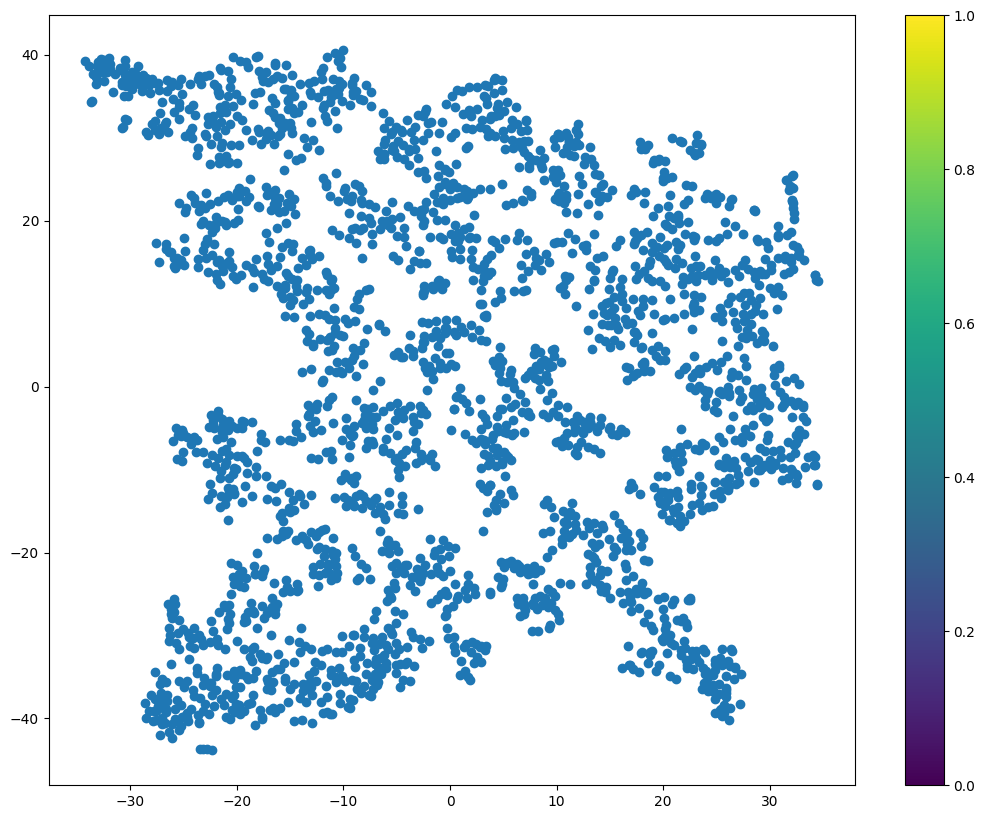

In [27]:
from sklearn.manifold import TSNE

# Concatenate the specific feature sets from two DataFrames (x and testin_x) for dimensionality reduction.
# Assuming 'feats' is a list of feature names that you want to include in the t-SNE transformation.
df = pd.concat([x[feats], testin_x[feats]])

# Initialize the t-SNE transformation with two components, setting the random state for reproducibility,
# a perplexity of 50 for balancing attention between local and global aspects of the data,
# and enabling verbose output to monitor the process.
t_sne = TSNE(n_components=2, random_state=42, perplexity=50, n_jobs=-1, verbose=True)

# Apply the t-SNE transformation to the data, filling any missing values with zero.
# The result is a two-dimensional representation of the original data.
df_tsne = t_sne.fit_transform(df.fillna(0))

# Import matplotlib for data visualization.
import matplotlib.pyplot as plt

# Create a figure with specific dimensions for plotting.
plt.figure(figsize=(13,10))
# Scatter plot of the two components obtained from t-SNE. The points are color-coded by a jet colormap.
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap="jet")
# Add a color bar to the plot to indicate data density or another variable if specified.
plt.colorbar()
# Display the plot.
plt.show()

# Split the t-SNE results back into the original training and testing sets.
# Assign the first component values to a new column 'tsne_0' in the training set 'x'.
x['tsne_0'] = df_tsne[:x.shape[0], 0]
# Assign the second component values to another new column 'tsne_1' in the training set 'x'.
x['tsne_1'] = df_tsne[:x.shape[0], 1]

# Assign the first component values to a new column 'tsne_0' in the testing set 'testin_x'.
testin_x['tsne_0'] = df_tsne[x.shape[0]:, 0]
# Assign the second component values to another new column 'tsne_1' in the testing set 'testin_x'.
testin_x['tsne_1'] = df_tsne[x.shape[0]:, 1]


Key Points of the Process:

Data Preparation:

The data from both training and testing datasets (x and testin_x) are concatenated based on the selected features (feats). This is typically done to ensure the t-SNE transformation is consistent across the entire dataset.

t-SNE Transformation:

t-SNE is applied to the combined data, where it maps the high-dimensional data into two dimensions. This reduction allows for visual exploration of the data’s structure at a lower dimension, often revealing patterns such as clusters.

Visualization:

A scatter plot is used to visualize the results of the t-SNE. Each point represents an observation in the dataset, with its position determined by the two t-SNE components. The color mapping (cmap="jet") helps to differentiate the data points based on their density or another variable if specified.


Feature Addition:

The transformed features (tsne_0 and tsne_1) are added back into the original training and testing datasets. This step allows for these new features to be used in subsequent analyses, potentially aiding in tasks like clustering or classification where spatial relationships are informative.

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 2474 samples in 0.003s...
[t-SNE] Computed neighbors for 2474 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2474
[t-SNE] Computed conditional probabilities for sample 2000 / 2474
[t-SNE] Computed conditional probabilities for sample 2474 / 2474
[t-SNE] Mean sigma: 38989.599045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.450485
[t-SNE] KL divergence after 1000 iterations: 0.730110


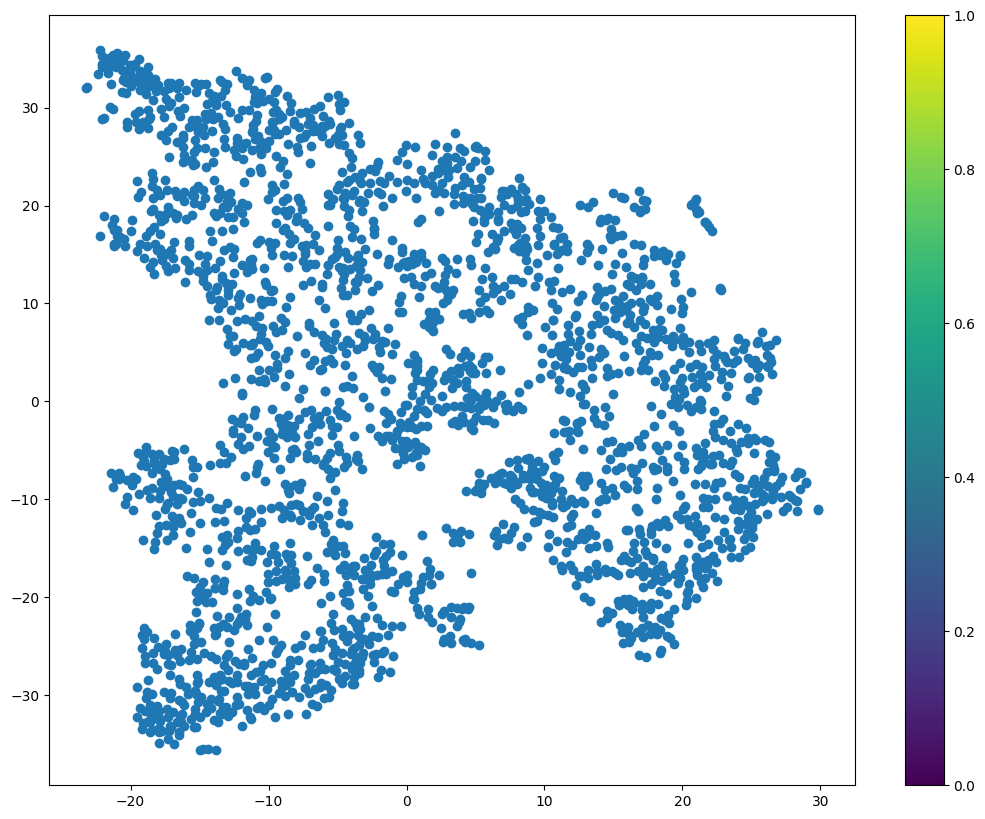

In [28]:
from sklearn.manifold import TSNE
#For Features Adding
df = pd.concat([x[feats],testin_x[feats]])

t_sne = TSNE(n_components=2, random_state=42, perplexity=80, n_jobs=-1, verbose=True)  #perplexity of 80
df_tsne = t_sne.fit_transform(df.fillna(0))

plt.figure(figsize=(13,10))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap="jet")
plt.colorbar()
plt.show()

x['_tsne_0'] = df_tsne[:x.shape[0],0]
x['_tsne_1'] = df_tsne[:x.shape[0],1]

testin_x['_tsne_0'] = df_tsne[x.shape[0]:,0]
testin_x['_tsne_1'] = df_tsne[x.shape[0]:,1]

Perplexity Adjustment:
 The perplexity has been increased from 50 to 80. This generally encourages the algorithm to take a broader context into account and could potentially reveal more global groupings or structures within the data.

Point Distribution:
 The points are scattered throughout the plot without clear, discrete clusters. This might suggest that the data has a continuous nature or that distinct groups do not exist. However, there are some areas where the points are denser, which may indicate regions of local similarity within the higher-dimensional space.

Colour Gradient:
 The colour bar indicates a gradient from 0.0 to 1.0, though it's still unclear what this gradient represents. It could be a third dimension of data, such as a probability, density, or perhaps another feature's value associated with each point.

KL Divergence:
 The title of the graph indicates "KL divergence after 1000 iterations: 0.5224." KL divergence measures how much one probability distribution diverges from a second, expected probability distribution. In the context of t-SNE, it's used as part of the cost function that the algorithm minimizes. A lower KL divergence suggests that the low-dimensional representation is a more faithful representation of the high-dimensional data. The reported value provides a sense of the quality of the embedding.



With a perplexity of 80, the structure may appear less tight than with a lower perplexity, potentially making global trends more apparent while local clusters might become less distinct. However, without any marked change in the point distribution as compared to the previous graph with a perplexity of 50, it suggests that the dataset may not have distinct groupings, or other perplexity values and t-SNE parameters may need to be explored to uncover them.

In [29]:
#This function splits the data into training and validation sets based on provided indices.
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]   #Extract training features using the provided indices.
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid #Return the split datasets.


#Modify your evaluate function
##This function evaluates a model using stratified k-fold cross-validation and optionally performs predictions on a separate test set.
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))  # Preallocate array for storing cross-validation predictions.
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None  # Preallocate array for storing test predictions if a test set is provided.

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # Create stratified k-fold object with a fixed random state.
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)  # Create stratified k-fold object with variable random state depending on the bag.
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)  # Split data into training and validation sets.

            model = TabPFNClassifier(device='cuda', N_ensemble_configurations=1)  # Instantiate the model (note: this should probably not be inside the loop).

            model.fit(train_x, train_y, overwrite_warning=True)  # Fit the model on the training data.

            cv_predictions = model.predict_proba(valid_x)  # Predict probabilities on the validation set.
            cv_results[valid_index, :] = cv_predictions  # Store the validation predictions.

            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits  # Predict probabilities on the test set and average over the splits.

    if test_x is not None:
        return cv_results, test_results  # Return cross-validation and test results.
    else:
        return cv_results, None  # Return only cross-validation results if no test set is provided.

In [30]:
from tqdm import tqdm

In [31]:
pip install tabpfn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [32]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


In [33]:
pip install torch===<version>+cpu torchvision===<version>+cpu torchaudio===<version> -f https://download.pytorch.org/whl/torch_stable.html


/bin/bash: line 1: version: No such file or directory


In [34]:
import torch


In [35]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import scipy.stats as stats
# A dictionary to remap the scores to a custom scale. This could be specific to how scores are evaluated or prioritised in your model.
vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}
# Map the original scores in 'y' to new values defined in the 'vals' dictionary for modelling.
_y = pd.Series(y).map(vals)
_y
# Initialise the TabPFNClassifier model specifying to use a single ensemble configuration and to run computations on a GPU.
solution = TabPFNClassifier(device='cuda',N_ensemble_configurations=1)

# Principal Component Analysis (PCA) is initialised to reduce the dimensionality of the data to 100 principal components.
p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
# Concatenate the training and testing data.
df = pd.concat([x, testin_x])
# Fit PCA on the combined data after filling any missing values with zeros.
pca.fit(df.fillna(0))
# Transform the training and testing datasets to their new reduced dimensions.
_x = pca.transform(x.fillna(0))
_testin_x = pca.transform(testin_x.fillna(0))

# The 'evaluate' function is called to perform model validation and testing.
# It uses 1 bagging iteration, 5-fold cross-validation and provides test data for additional evaluation.
oof_prob_1, oof_prob_test_1 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
# Output the out-of-fold prediction probabilities for the training data.
oof_prob_1


We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.


0it [00:00, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_mod

array([[0.00387206, 0.03145267, 0.00440805, ..., 0.23355092, 0.23360793,
        0.33207569],
       [0.00309602, 0.01690776, 0.00297598, ..., 0.20784511, 0.27137065,
        0.32564881],
       [0.00445227, 0.07212976, 0.0047404 , ..., 0.40480003, 0.07511958,
        0.22305344],
       ...,
       [0.03561404, 0.25059244, 0.03390736, ..., 0.13575837, 0.11696102,
        0.18229456],
       [0.00557808, 0.11027271, 0.00418854, ..., 0.44847324, 0.04256611,
        0.15405147],
       [0.00657577, 0.04072808, 0.01863195, ..., 0.06171986, 0.27493891,
        0.1154494 ]])

In [36]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)

            model = MultinomialNB(alpha=1.0)

            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions
            cv_predictions = model.predict_proba(valid_x)
            cv_results[valid_index, :] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits

    if test_x is not None:
        return cv_results, test_results
    else:
        return cv_results, None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import scipy.stats as stats

vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}

_y = pd.Series(y).map(vals)
_y

solution = MultinomialNB(alpha=1.0)
p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
df = pd.concat([x,testin_x])
pca.fit(df.fillna(0))
_x = pca.transform(x.fillna(0))**2
_testin_x = pca.transform(testin_x.fillna(0))**2

oof_prob_2, oof_prob_test_2 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
oof_prob_2

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
5it [00:00, 137.58it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


# Modify your evaluate function
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), pd.Series(data_y).nunique()))
    test_results = np.zeros((len(test_x), pd.Series(data_y).nunique())) if test_x is not None else None

    for bag in range(n_bags):
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)

            model = MLPClassifier(random_state=42)

            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions
            cv_predictions = model.predict_proba(valid_x)
            cv_results[valid_index, :] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results += model.predict_proba(test_x) / n_splits

    if test_x is not None:
        return cv_results, test_results
    else:
        return cv_results, None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from xgboost import XGBRegressor, XGBClassifier
from tabpfn import TabPFNClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import scipy.stats as stats

vals = {4.0: 9,
 3.5: 8,
 4.5: 7,
 3.0: 6,
 2.5: 5,
 5.0: 4,
 5.5: 1,
 2.0: 3,
 1.5: 2,
 6.0: 1,
 1.0: 0,
 0.5: 0}

_y = pd.Series(y).map(vals)
_y

solution = MLPClassifier(random_state=42)
p_comp = 100
pca = PCA(n_components=p_comp, random_state=42)
df = pd.concat([x,testin_x])
pca.fit(df.fillna(0))
_x = pca.transform(x.fillna(0))**2
_testin_x = pca.transform(testin_x.fillna(0))**2

oof_prob_3, oof_prob_test_3 = evaluate(_x.copy(), _y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
oof_prob_3

5it [00:01,  2.68it/s]


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [40]:
# Create copies of the training and testing datasets to ensure the original data remains unchanged.
_x = x.copy()
_testin_x = testin_x.copy()

# Add prediction probabilities from a tabular model (from TabPFNClassifier as mentioned previously) as new features to the datasets.
# 'oof_prob_1' contains the out-of-fold probabilities from the training data,
# and 'oof_prob_test_1' contains the corresponding probabilities from the testing data.
_x[[f'probs_tab_{i}' for i in range(10)]] = oof_prob_1.copy()
_testin_x[[f'probs_tab_{i}' for i in range(10)]] = oof_prob_test_1.copy()

# Add prediction probabilities from another model, referred to here as 'nb' ( Naive Bayes or another classifier),
# as additional features to the datasets.
_x[[f'probs_nb_{i}' for i in range(10)]] = oof_prob_2.copy()
_testin_x[[f'probs_nb_{i}' for i in range(10)]] = oof_prob_test_2.copy()

# Add prediction probabilities from a neural network model (MLPC) as further features to the datasets.
_x[[f'probs_nn_{i}' for i in range(10)]] = oof_prob_3.copy()
_testin_x[[f'probs_nn_{i}' for i in range(10)]] = oof_prob_test_3.copy()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
vals = {4.0: 9, 3.5: 8, 4.5: 7, 3.0: 6, 2.5: 5, 5.0: 4, 5.5: 1, 2.0: 3, 1.5: 2, 6.0: 1, 1.0: 0, 0.5: 0}#dictionary maps original score values to a new scale.
Inversemapper = {0:1, 1:6, 2: 1.5, 3:2, 4:5, 5: 2.5, 6:3, 7:4.5, 8:3.5, 9:4}##This is the inverse of the initial mapping, used to interpret model outputs back into the original scoring scale.

## new feat
#This function calculates a weighted sum of model predictions. Each model output component (probability) is multiplied by the
#corresponding score from the inverse mapping, then all are summed to give a single score.
def f(x):
    s = 0
    for i, y in enumerate(x):
        s += y * Inversemapper[i]
    return s
for str_model in ['probs_tab_','probs_nb_','probs_nn_']:                                                              #Loop over each set of model predictions ('probs_tab_', 'probs_nb_', 'probs_nn_') to compute a weighted sum
    _x[f'{str_model}w_sum'] = _x[[f'{str_model}{i}' for i in range(10)]].apply(f, axis=1)                             #using the function defined above. This transforms the model probabilities into a single summary score.
    _testin_x[f'{str_model}w_sum'] = _testin_x[[f'{str_model}{i}' for i in range(10)]].apply(f, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
#This function is used to divide the data into training and validation sets based on indices generated from the stratified k-fold process
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]     ##Select training data using the provided indices
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid
###.iloc: Ensures that data selection is based on integer-location based indexing, which is important when working with subsets of pandas DataFrames.




# Modify your evaluate function
##This function evaluates a model using stratified k-fold cross-validation, incorporating bagging if specified, and optionally predicts on a test set.
def evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None):
    cv_results = np.zeros((len(data_x), n_bags))       # Initialise matrices to hold cross-validation and test results.
    test_results = np.zeros((len(test_x), n_bags)) if test_x is not None else None

    for bag in range(n_bags): ##loop iter
        if n_bags == 1:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=bag)
        for i, (train_index, valid_index) in tqdm(enumerate(skf.split(data_x, data_y.astype(str)))):        #Perform stratified k-fold splitting.
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index) #split train and val


            # First training on the original training set
            model.fit(train_x, train_y)

            # Store the predictions=
            cv_predictions = model.predict(valid_x)
            cv_results[valid_index, bag] = cv_predictions

            # Predict on test set if available
            if test_x is not None:
                test_results[:, bag] += model.predict(test_x) / n_splits
    # Calculate the mean predictions across bags for both cross-validation and test results.
    if test_x is not None:
        return np.mean(cv_results, axis=1), np.mean(test_results, axis=1)
    else:
        return np.mean(cv_results, axis=1), None


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import scipy.stats as stats
param = {
    'n_estimators': 1000,  # The number of trees to build.
    'learning_rate': 0.01,  # The step size shrinkage used to prevent overfitting.
    'max_depth': 4,         # The maximum depth of a tree.
    'subsample': 0.3,       # The fraction of samples to be used for each tree. Lower values make the algorithm more conservative and prevent overfitting.
    'objective': 'reg:squarederror',  # The loss function to be minimised, in this case, squared error for regression.
    'random_state': 42      # A seed used for reproducibility of results.
}

solution = XGBRegressor(**param)
oof_3, test_results_xg_2 = evaluate(_x.copy(), y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5)
print('XG CV RMSE: ',mean_squared_error(y,oof_3,squared=False))
spearman_correlation, p_value = stats.spearmanr(y, oof_3)
print('Spearman Correlation Coefficient: ', spearman_correlation)

5it [00:32,  6.46s/it]

XG CV RMSE:  0.5938821535429444
Spearman Correlation Coefficient:  0.8176566687013261


In [44]:
from sklearn.model_selection import KFold ###for the feats importances

def Evaluate(data_x, data_y, model, n_splits=5, n_bags=1, test_x=None, collect_importances=False):
    cv_results = np.zeros((len(data_x), n_bags))
    test_results = np.zeros((len(test_x), n_bags)) if test_x is not None else None

    feature_importances = []

    for im_bag in range(n_bags):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=im_bag if n_bags > 1 else 42)
        for train_index, valid_index in kf.split(data_x):
            train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
            model.fit(train_x, train_y)
            cv_predictions = model.predict(valid_x)
            cv_results[valid_index, im_bag] = cv_predictions
            if test_x is not None:
                test_results[:, im_bag] += model.predict(test_x) / n_splits

            if collect_importances and hasattr(model, 'feature_importances_'):
                feature_importances.append(model.feature_importances_)

    feature_importances = np.mean(feature_importances, axis=0) if collect_importances else None
    if test_x is not None:
        return np.mean(cv_results, axis=1), np.mean(test_results, axis=1), feature_importances
    else:
        return np.mean(cv_results, axis=1), None, feature_importances

solution = XGBRegressor(**param)
oof_3, test_results_xg_2, importances = Evaluate(_x.copy(), y.copy(), solution, n_bags=1, test_x=_testin_x.copy(), n_splits=5, collect_importances=True)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

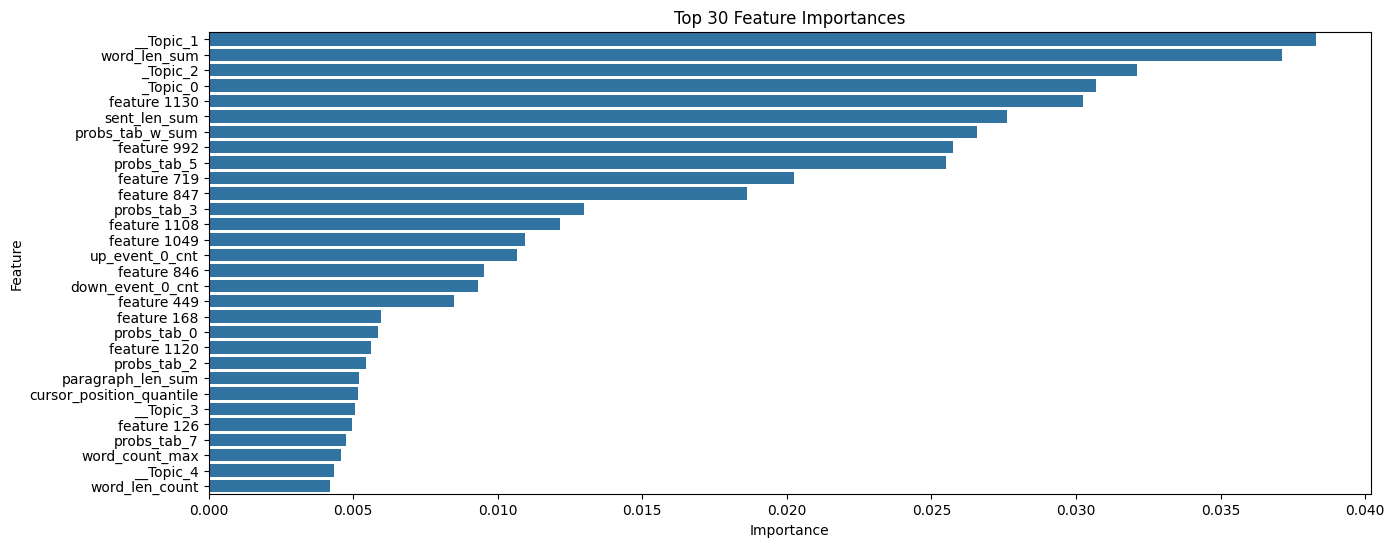

In [45]:
# Plot feature importances
if importances is not None:
    fig, ax = plt.subplots(figsize=(15, 6))
    feature_importance_df = pd.DataFrame({'Feature': _x.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(30)
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    ax.set_title('Top 30 Feature Importances')
    plt.show()

In [46]:
from catboost import CatBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, Ridge,PassiveAggressiveRegressor,HuberRegressor, PoissonRegressor,BayesianRidge
from sklearn.preprocessing import MinMaxScaler


solution1 = LinearSVR(C=0.9,loss='squared_epsilon_insensitive')
solution2 = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42,selection='cyclic')
solution3 = Ridge(alpha=10)
solution4 = PassiveAggressiveRegressor(C=0.001,loss='squared_epsilon_insensitive')
solution5 = HuberRegressor(epsilon=1.25, alpha=20)
solution6 = PoissonRegressor(alpha=0.01)
solution7 = BayesianRidge()


models = [solution1,solution2,solution3,solution4,solution5,solution6,solution7]

sc = MinMaxScaler()
df = pd.concat([_x,_testin_x])
sc.fit(df)
__x = pd.DataFrame(sc.transform(_x), columns=_x.columns)
__testin_x = pd.DataFrame(sc.transform(_testin_x), columns=_x.columns)

oof_linear = pd.DataFrame(0,index=__x.index,columns=range(7))
oof_test = pd.DataFrame(0,index=__testin_x.index,columns=range(7))

for i, model in tqdm(enumerate(models)):
    oof_preds, test_preds = evaluate(__x.fillna(0).copy(), y.copy(), model, n_bags=1, test_x=__testin_x.fillna(0).copy(), n_splits=5)
    oof_preds = np.clip(oof_preds,0,6)
    test_preds = np.clip(test_preds,0,6)
    oof_linear.loc[:,i] = oof_preds.copy()
    oof_test.loc[:,i] = test_preds.copy()
    print('CV RMSE: ',mean_squared_error(y,oof_preds,squared=False))
print('Finished!!')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.94it/s]
2it [00:01,  1.88it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.83it/s]
5it [00:02,  1.84it/s]
1it [00:02,  2.73s/it]

CV RMSE:  0.6296965188571766



0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  2.90it/s]
3it [00:01,  2.89it/s]
4it [00:01,  2.68it/s]
5it [00:01,  2.77it/s]
2it [00:04,  2.21s/it]

CV RMSE:  0.6236512339807666



0it [00:00, ?it/s]
2it [00:00, 17.31it/s]
5it [00:00, 16.56it/s]
3it [00:04,  1.35s/it]

CV RMSE:  0.6257370686251814



0it [00:00, ?it/s]
1it [00:00,  6.82it/s]
2it [00:00,  7.99it/s]
3it [00:00,  7.50it/s]
4it [00:00,  8.23it/s]
5it [00:00,  8.12it/s]
4it [00:05,  1.07s/it]

CV RMSE:  0.63084912375813



0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

1it [00:00,  2.88it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

2it [00:00,  3.11it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of I

CV RMSE:  0.6288250759422795



0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)

1it [00:05,  5.92s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)

2it [00:12,  6.08s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

CV RMSE:  0.6322989183072577



0it [00:00, ?it/s]
1it [00:00,  5.34it/s]
2it [00:00,  4.69it/s]
3it [00:00,  4.87it/s]
4it [00:00,  5.45it/s]
5it [00:00,  5.31it/s]
7it [00:40,  5.76s/it]

CV RMSE:  0.6250627808664981
Finished!!


In [47]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def weighted_rmse(weights, subs, y_true):
    """Compute weighted RMSE for the ensemble predictions."""
    ensemble_prediction = np.dot(weights, subs.T)
    return mean_squared_error(y_true, ensemble_prediction, squared=False)


# Initial weights (starting point for the optimization)
initial_weights = [0 for i in range(7)]

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Bounds for each weight to be between 0 and 1
bounds = [(0, 1) for i in range(7)]

subs = oof_linear

# Perform optimization
opt_result = minimize(weighted_rmse, initial_weights, args=(subs, y),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

print("Optimal weights:", optimal_weights)
print('Optimized Ensemble CV RMSE: ', weighted_rmse(optimal_weights, subs, y))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal weights: [3.14926242e-01 3.91892228e-01 0.00000000e+00 4.55364912e-17
 2.93181529e-01 1.95156391e-17 2.55871713e-17]
Optimized Ensemble CV RMSE:  0.6224600465433489


In [48]:
oof_linear = (oof_linear.loc[:,0] * optimal_weights[0]) + (oof_linear.loc[:,1] * optimal_weights[1]) + (oof_linear.loc[:,2] * optimal_weights[2]) + (oof_linear.loc[:,3] * optimal_weights[3]) + (oof_linear.loc[:,4] * optimal_weights[4]) + (oof_linear.loc[:,5] * optimal_weights[5]) + (oof_linear.loc[:,6] * optimal_weights[6])
oof_test = (oof_test.loc[:,0] * optimal_weights[0]) + (oof_test.loc[:,1] * optimal_weights[1]) + (oof_test.loc[:,2] * optimal_weights[2]) + (oof_test.loc[:,3] * optimal_weights[3]) + (oof_test.loc[:,4] * optimal_weights[4]) + (oof_test.loc[:,5] * optimal_weights[5]) + (oof_test.loc[:,6] * optimal_weights[6])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OW

In [49]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def weighted_rmse(weights, subs, y_true):
    """Compute weighted RMSE for the ensemble predictions."""
    ensemble_prediction = np.dot(weights, subs)
    return mean_squared_error(y_true, ensemble_prediction, squared=False)


# Initial weights (starting point for the optimization)
initial_weights = [0, 0]

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Bounds for each weight to be between 0 and 1
bounds = [(0, 1), (0, 1)]

subs = [oof_3, oof_linear.values]

# Perform optimization
opt_result = minimize(weighted_rmse, initial_weights, args=(subs, y),
                      method='Nelder-Mead', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

print("Optimal weights:", optimal_weights)
print('Optimized Ensemble CV RMSE: ', weighted_rmse(optimal_weights, subs, y))


Optimal weights: [0.78737994 0.21252804]
Optimized Ensemble CV RMSE:  0.5913712498558414


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [50]:
ensemble_sub = pd.DataFrame({'id': test_ids})
W = optimal_weights

ensemble_sub['score'] =  (test_results_xg_2 * W[0]) + (oof_test * W[1])
ensemble_sub

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id     score
0  0000aaaa  1.895357
1  2222bbbb  1.782546
2  4444cccc  1.807476

In [51]:
ensemble_sub.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo